In [1]:
write_images = False


wirte_output_txt = False 
# Specify everytime Simulation is called 
# WARNING --> Set to False when running more then 10 simulations 
#            (otherwise it will be super slow and might crash)

In [2]:
import numpy as np

In [3]:
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.initial_designs import RandomDesign

import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity

import matplotlib.pyplot as plt
import mlai.plot as plot

In [4]:
%run Missile_utils.ipynb

In [5]:
simulation_output = 'range' 
# We divide by 1000 to avoid dealing with too large numbers

We consider missiles with only 1 stage

In [6]:

basic_param_spaces = {
    'payload':  [10, 2410],
    'missilediam':  [0.1, 9.9],
    'rvdiam':  [0.1, 9.9],
    'estrange': [100, 4900], 
    'fuelmass': [500, 6000], # [500, 7000], 
    'drymass':  [1000, 3000],
    'Isp0':  [100, 800],# [100, 800],
    'thrust0':  [10000, 69000],
}

In [7]:
from sklearn.metrics import mean_squared_error
import math

# TODO: improve considering also the variance 
# (i.e. penalise less if mean prediction is not accurate, but still within 2 std dev?)
def compute_rmse(y_actual, y_predicted):
    MSE = mean_squared_error(y_actual, y_predicted)
    RMSE = math.sqrt(MSE)
 
    return RMSE

def evaluate_prediction(y_actual, y_predicted):
    return compute_rmse(y_actual, y_predicted)
    
    

## 2. Maximize range

The central idea of the acquisition function is to trade off the exploration of regions where the model is uncertain and the exploitation of the model’s confidence about good areas of the input space. There are a variety of acquisition functions in Emukit. In this example the expected improvement [3], that computes in expectation how much we can improve with respect to the current best observed location.

Bayesian optimization iterates the following three steps until it achieves a predefined stopping criterion (normally using a fixed number of evaluations).

1. Find the next point to evaluate the objective by using a numerical solver to optimize the acquisition/utility.
2. Evaluate the objective in that location and add the new observation to the data set.
3. Update the model using the currently available data.


In [8]:
m3_param_1 = 'fuelmass'
m3_param_2 = 'Isp0'
m3_param_3 = 'drymass'
m3_param_4 = 'thrust0'
# m3_param_5 = 'payload'
# m3_param_6 = 'missilediam'
# I am not sure 'estrange' and 'rvdiam' can be changed freely

m3_domain_param_1 = basic_param_spaces[m3_param_1] # [500, 6000] # [5000,15000]
m3_domain_param_2 = basic_param_spaces[m3_param_2] # [200, 300] # [224, 228]
m3_domain_param_3 = basic_param_spaces[m3_param_3] 
m3_domain_param_4 = basic_param_spaces[m3_param_4] 
# m3_domain_param_5 = basic_param_spaces[m3_param_5] 
# m3_domain_param_6 = basic_param_spaces[m3_param_6] 


m3_space = ParameterSpace(
          [ContinuousParameter(m3_param_1, *m3_domain_param_1), 
           ContinuousParameter(m3_param_2, *m3_domain_param_2),
           ContinuousParameter(m3_param_3, *m3_domain_param_3), 
           ContinuousParameter(m3_param_4, *m3_domain_param_4),
#            ContinuousParameter(m3_param_5, *m3_domain_param_5), 
#            ContinuousParameter(m3_param_6, *m3_domain_param_6),
          ])
custom_param_names = [m3_param_1, m3_param_2, m3_param_3, m3_param_4, 
#                       m3_param_5, m3_param_6
                     ]
nr_custom_params = len(custom_param_names)

In [9]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION (Re-run since custom_param_names has changed)
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
                
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y



In [10]:
# To find the maximum of run_missile_sim, we will find the minimum of neg_run_missile_sim
def neg_run_missile_sim(custom_params):
    return -run_missile_sim(custom_params)




New simulation 

fuelmass: 2979.558410492879
Isp0: 611.6497467565857
drymass: 2036.3782594361144
thrust0: 37834.50694089811


Stage 1 burnout
Velocity (km/s):  4.237522182635933
Angle (deg h):  43.71809322897428
Range (km):  41.79320968536264
Time (sec):  48.200000000000415
Final results: 
Range (km):  2273.910635354264
Apogee (km):  640.7566540223396
Time to target (sec):  870.4000000001294




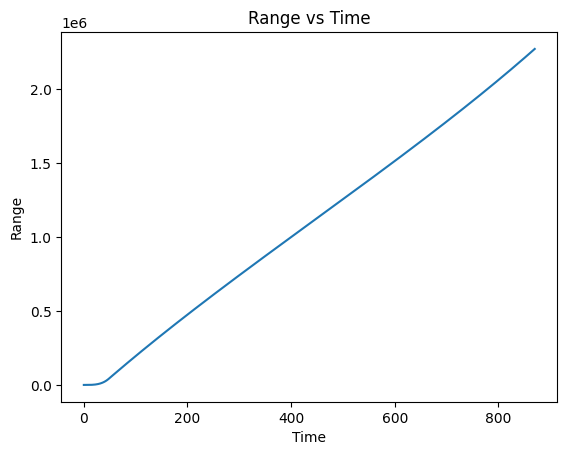

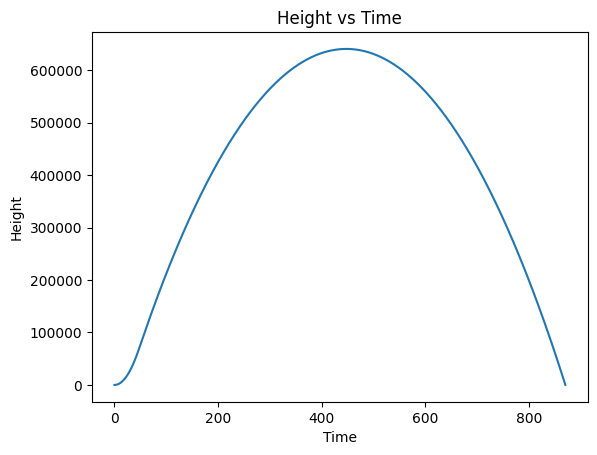

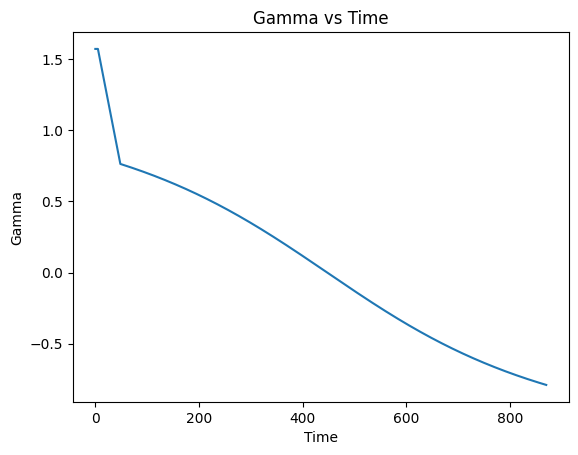

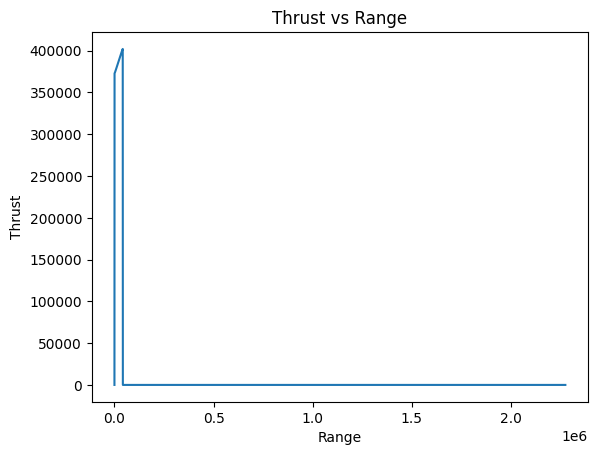

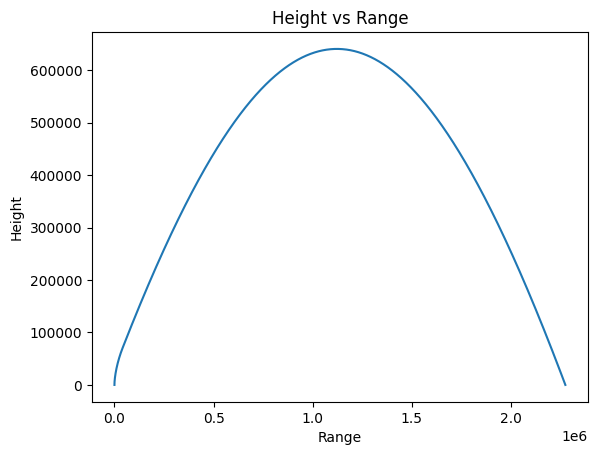

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 2341.836710097852
Isp0: 119.16255857689254
drymass: 2526.2954642585037
thrust0: 58059.095294881925


Stage 1 burnout
Velocity (km/s):  0.6102045328455667
Angle (deg h):  90.0
Range (km):  8.157003416881348e-17
Time (sec):  4.8
Final results: 
Range (km):  -2.264432629389333e-14
Apogee (km):  20.381526851678505
Time to target (sec):  131.9999999999968




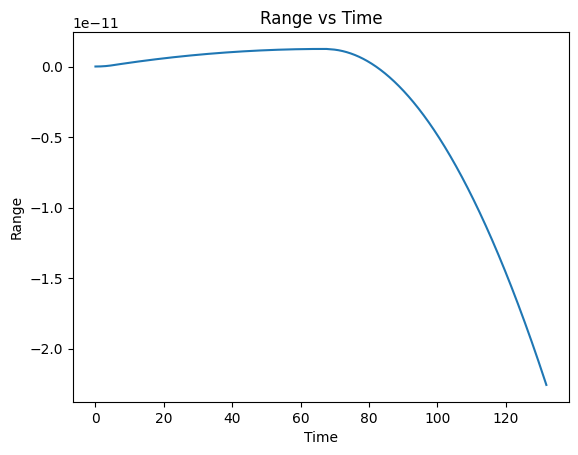

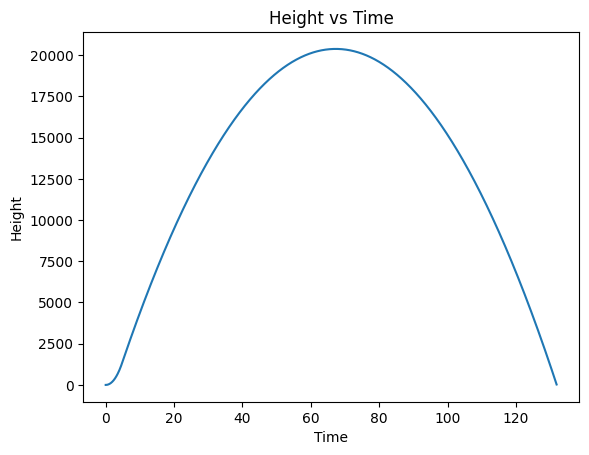

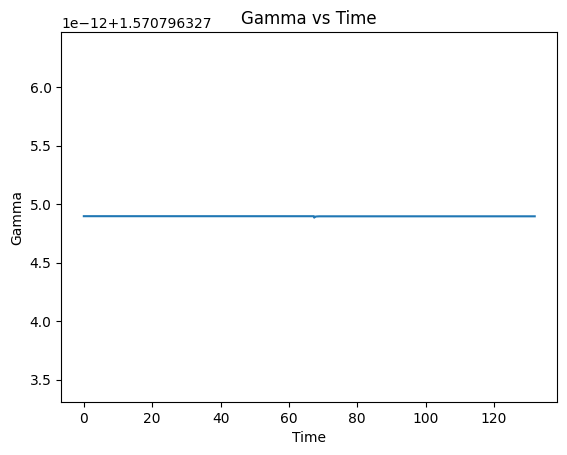

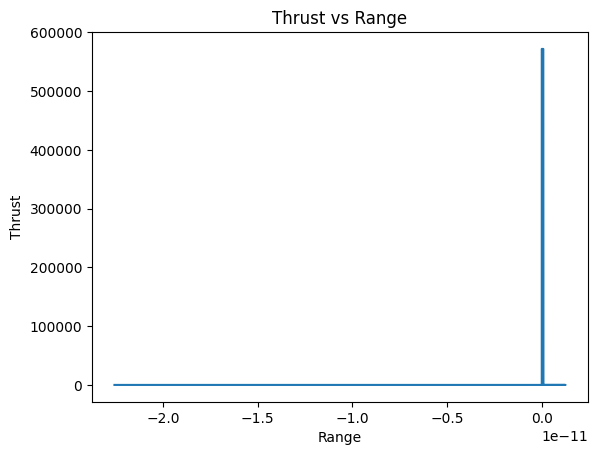

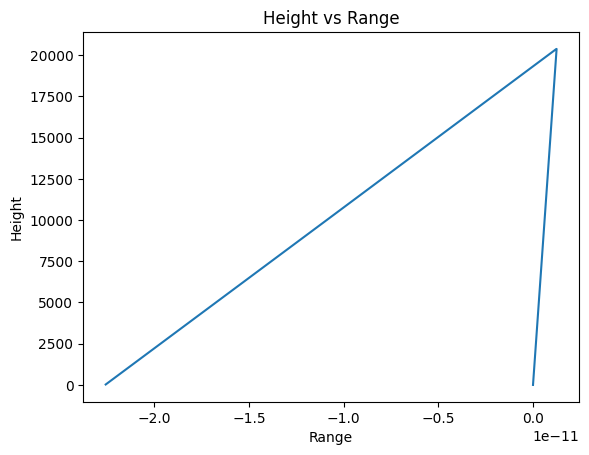

Data written to 'results/results_1.txt'

New simulation 

fuelmass: 5476.732943792105
Isp0: 106.7658443939008
drymass: 1736.7186323444316
thrust0: 38180.87954882852


Stage 1 burnout
Velocity (km/s):  1.0865071299336433
Angle (deg h):  43.71677827748986
Range (km):  2.8310231194545747
Time (sec):  15.299999999999963
Final results: 
Range (km):  130.13758666975946
Apogee (km):  34.94254074108774
Time to target (sec):  178.49999999999415




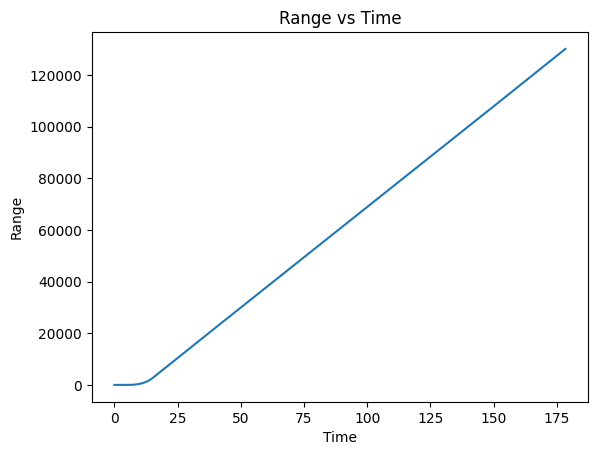

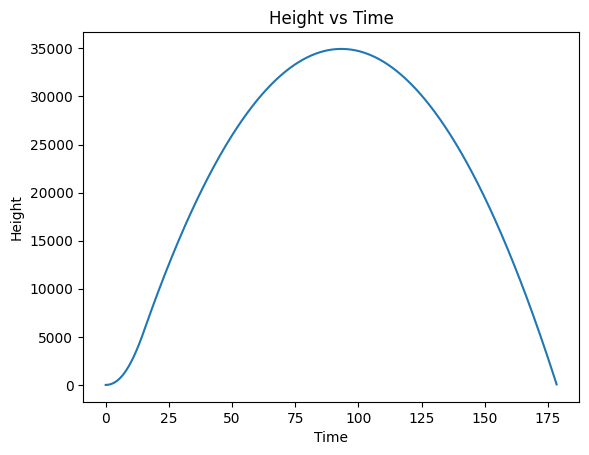

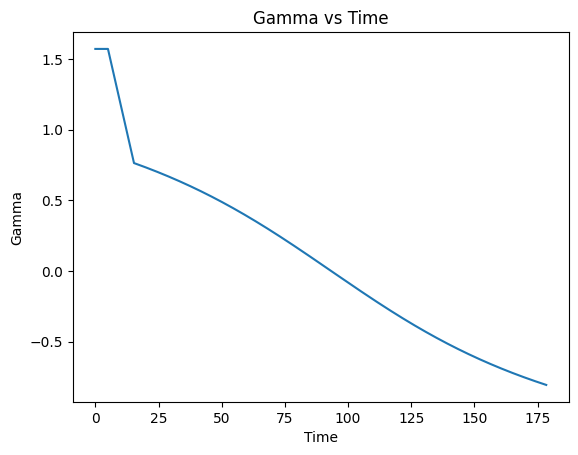

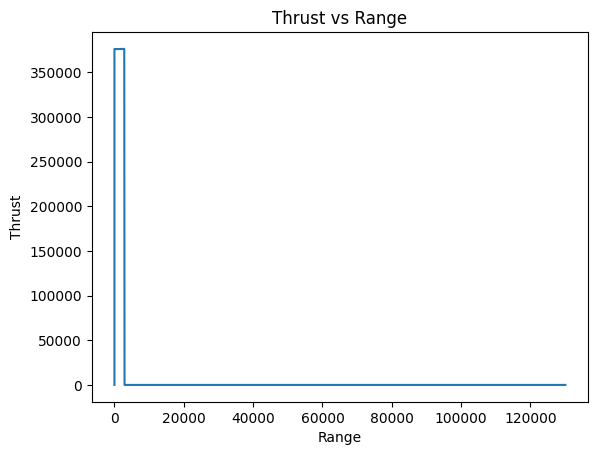

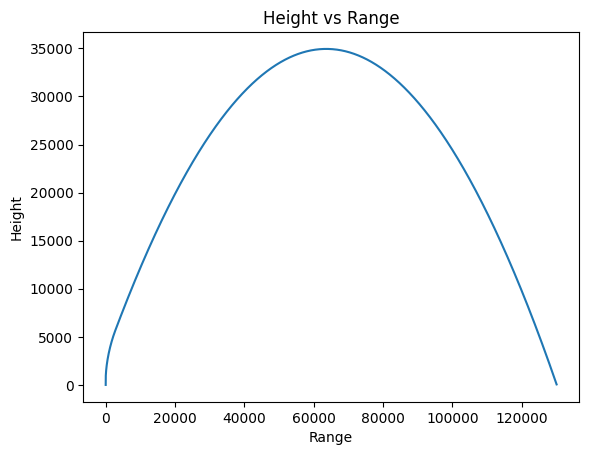

Data written to 'results/results_2.txt'

New simulation 

fuelmass: 1331.5364943480147
Isp0: 293.1081898200873
drymass: 1753.0359430489257
thrust0: 56046.6314026873


Stage 1 burnout
Velocity (km/s):  1.2064500253668888
Angle (deg h):  45.118188724609155
Range (km):  0.8296850009083607
Time (sec):  6.999999999999992
Final results: 
Range (km):  154.7432354858066
Apogee (km):  41.69882515549515
Time to target (sec):  189.29999999999353




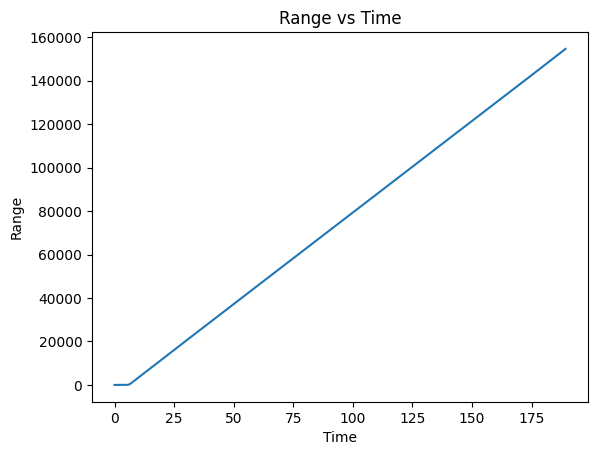

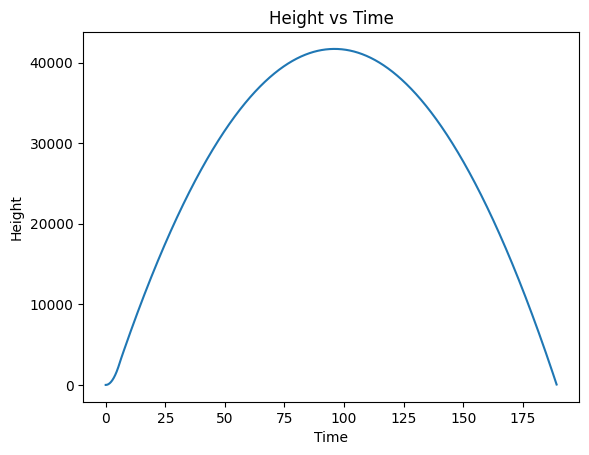

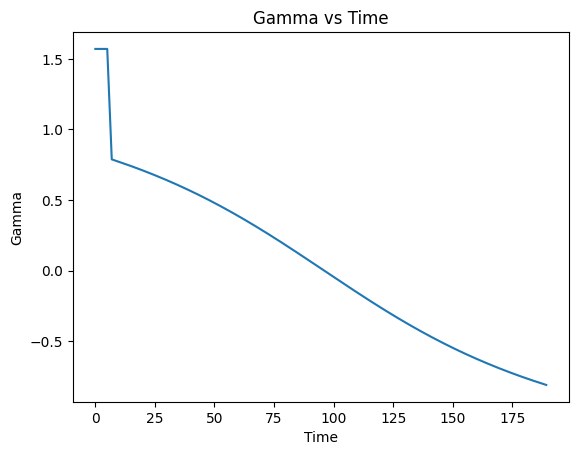

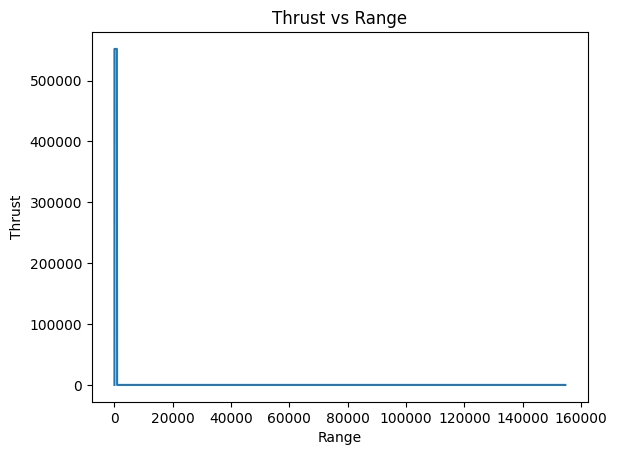

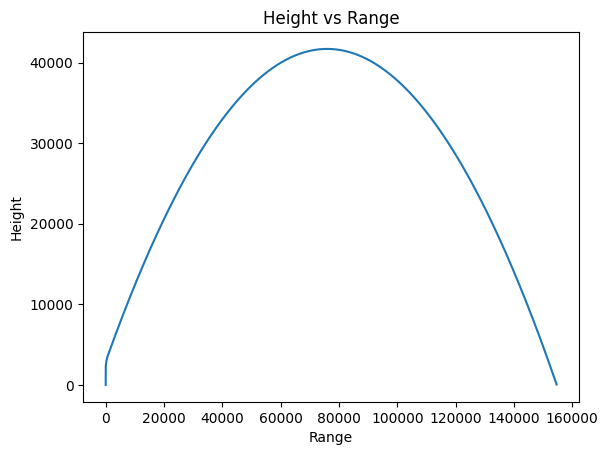

Data written to 'results/results_3.txt'

New simulation 

fuelmass: 521.0350657499403
Isp0: 710.4284955109338
drymass: 2073.1346806687825
thrust0: 20481.810987459718


Stage 1 burnout
Velocity (km/s):  1.0136138275228892
Angle (deg h):  43.86854733033496
Range (km):  3.8065488814969184
Time (sec):  18.09999999999999
Final results: 
Range (km):  117.32396760063999
Apogee (km):  33.52016039487543
Time to target (sec):  174.39999999999438




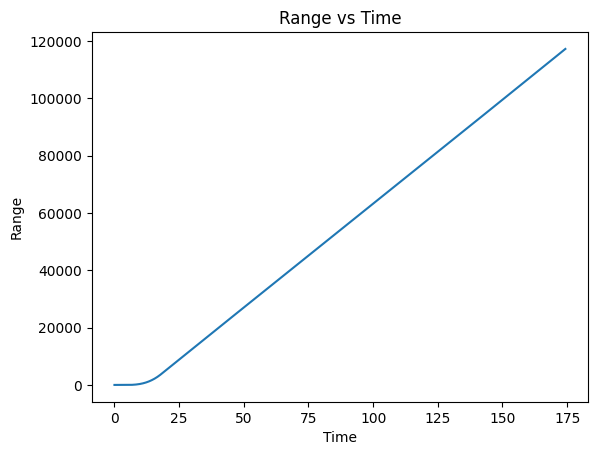

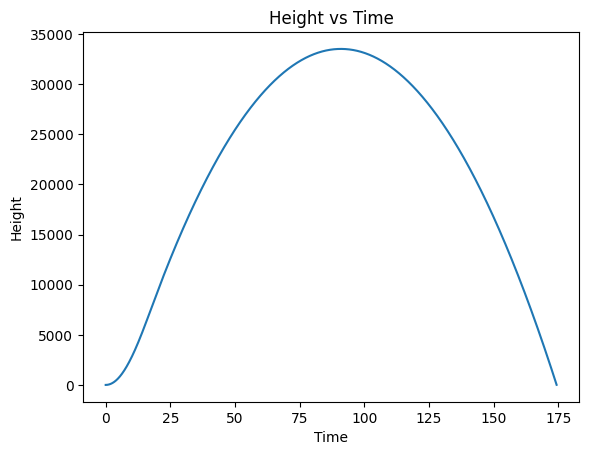

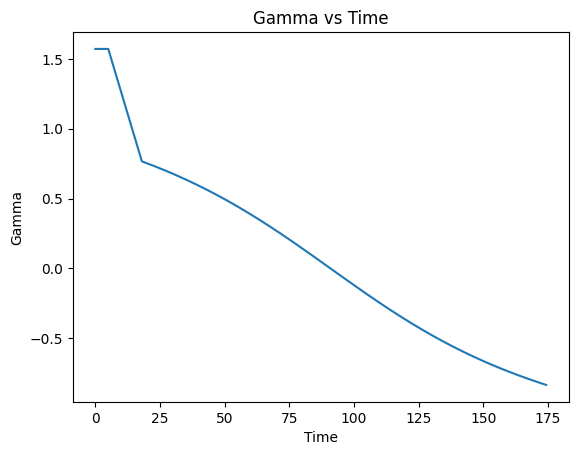

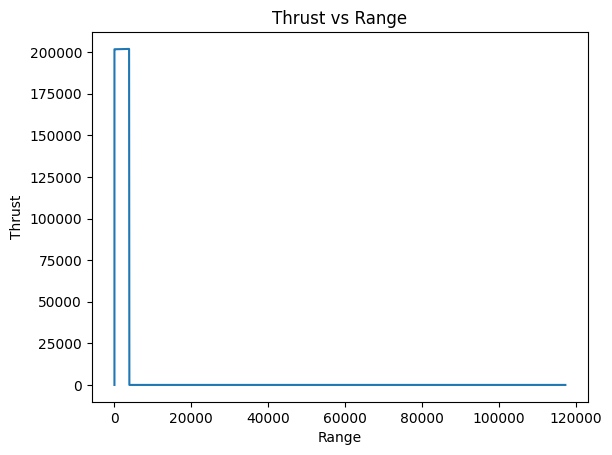

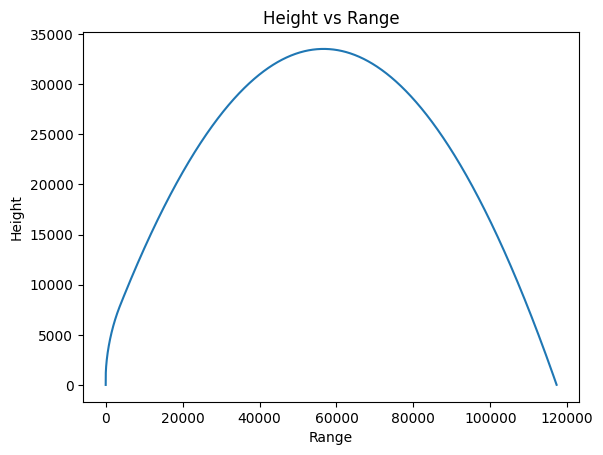

Data written to 'results/results_4.txt'

New simulation 

fuelmass: 1613.6913239777489
Isp0: 480.8028374306315
drymass: 2208.2032100171973
thrust0: 48158.77274016002


Stage 1 burnout
Velocity (km/s):  1.90834630460428
Angle (deg h):  43.695080647290204
Range (km):  5.905119874884416
Time (sec):  16.099999999999962
Final results: 
Range (km):  401.9383963651342
Apogee (km):  105.63457542216796
Time to target (sec):  309.1000000000018




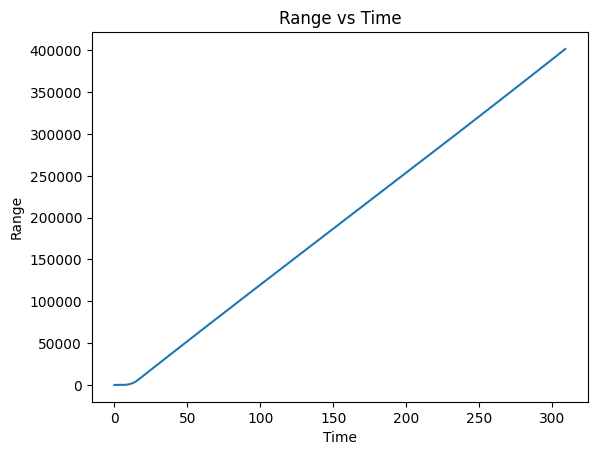

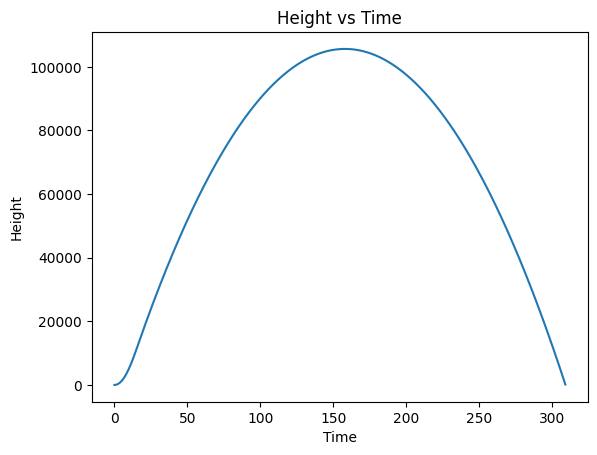

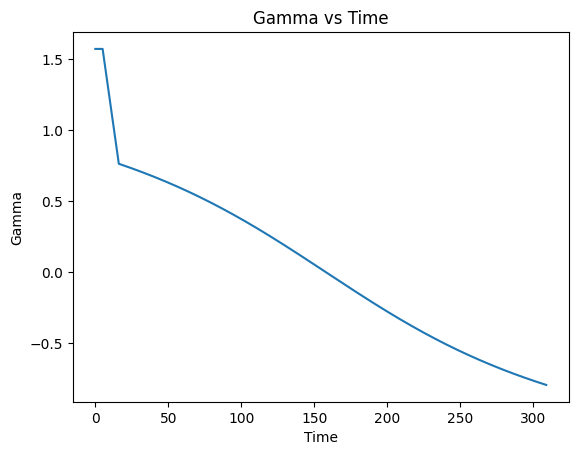

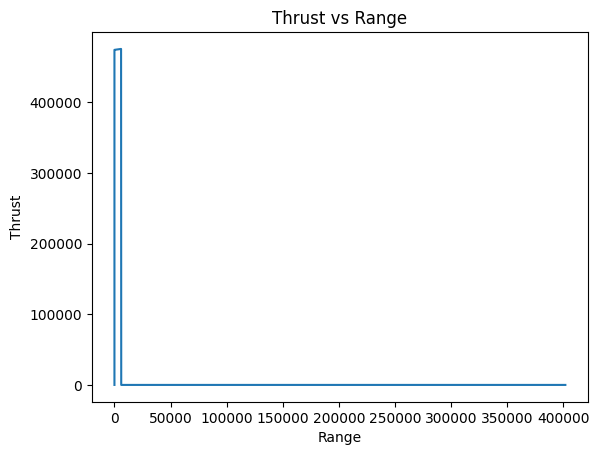

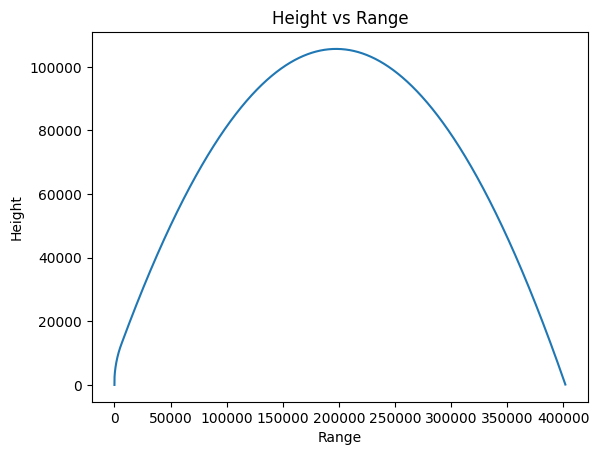

Data written to 'results/results_5.txt'

New simulation 

fuelmass: 4745.930928001597
Isp0: 519.359658916774
drymass: 2550.0865347732806
thrust0: 49424.07096652424


Stage 1 burnout
Velocity (km/s):  4.3912350312194794
Angle (deg h):  43.71826074618416
Range (km):  43.804272141411914
Time (sec):  49.90000000000044
Final results: 
Range (km):  2466.257437410564
Apogee (km):  698.1484660849782
Time to target (sec):  920.2000000001407




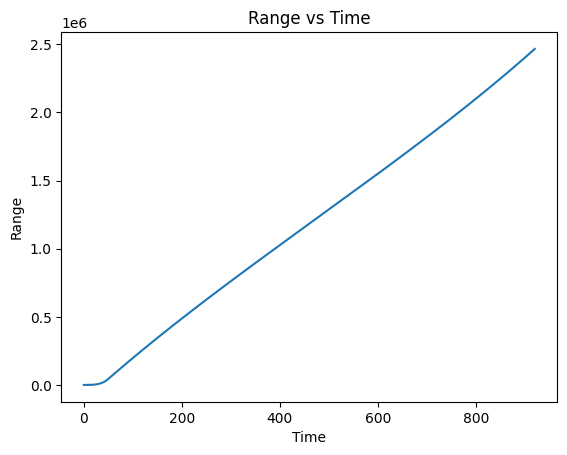

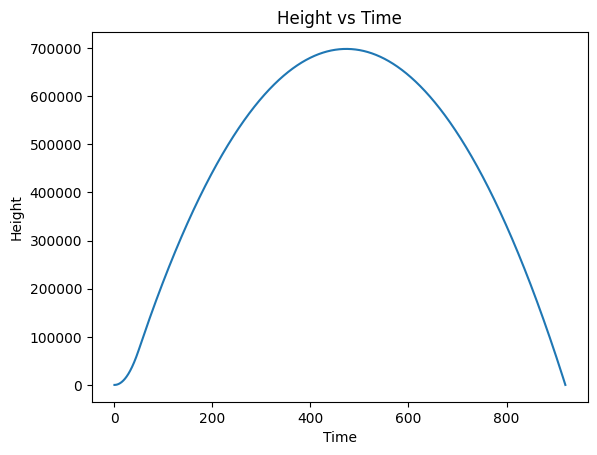

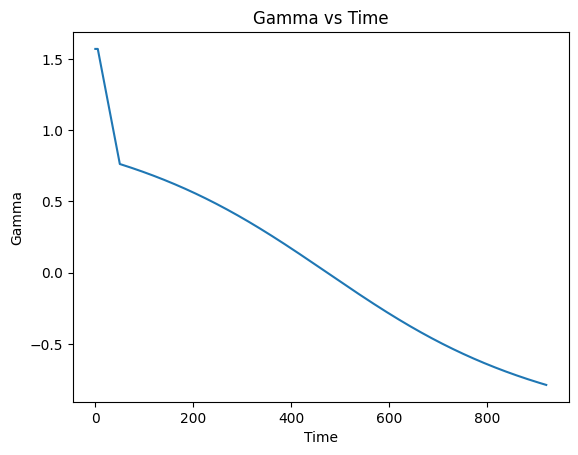

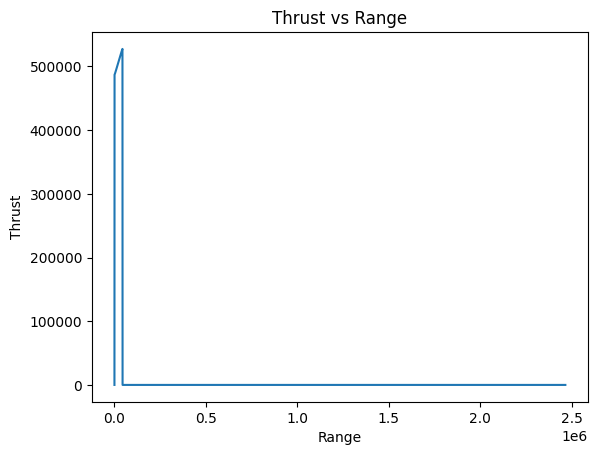

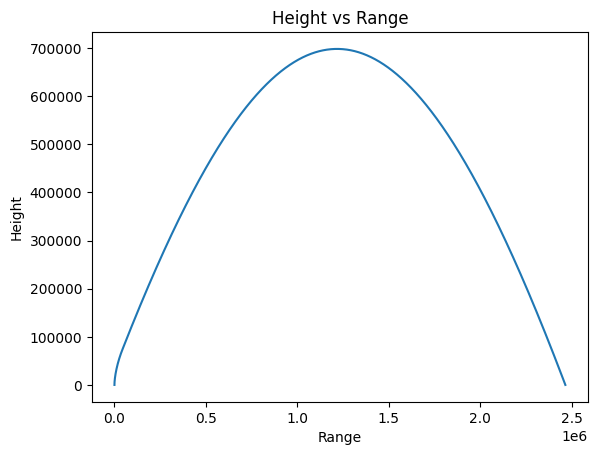

Data written to 'results/results_6.txt'

New simulation 

fuelmass: 3980.8222365426072
Isp0: 797.816833998209
drymass: 2433.950585037493
thrust0: 66799.99669207222


Stage 1 burnout
Velocity (km/s):  6.514602746819082
Angle (deg h):  43.69730854026116
Range (km):  62.37903239005121
Time (sec):  47.600000000000406
Final results: 
Range (km):  6479.017822866084
Apogee (km):  2167.481306442799
Time to target (sec):  2042.399999999238




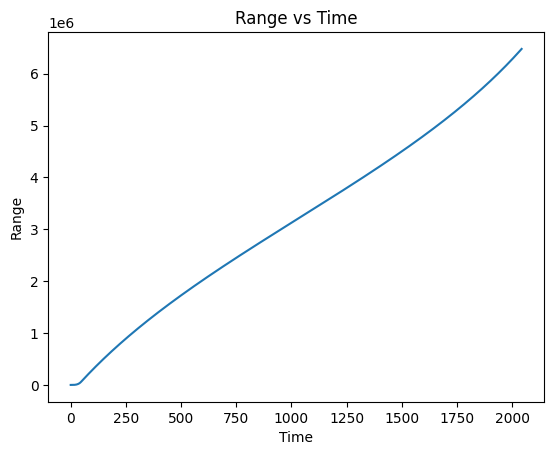

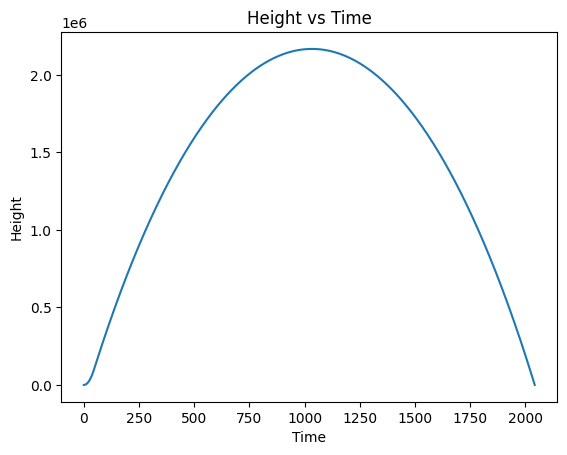

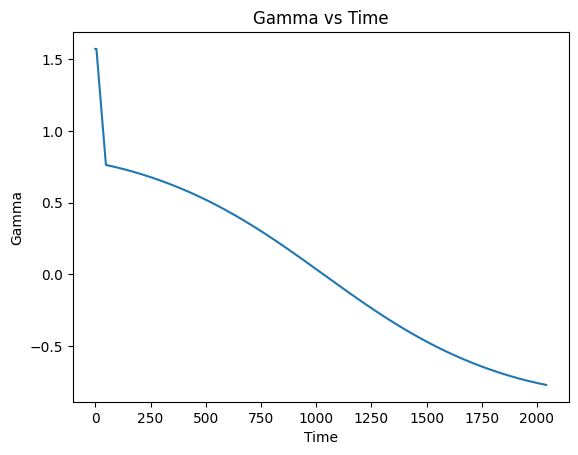

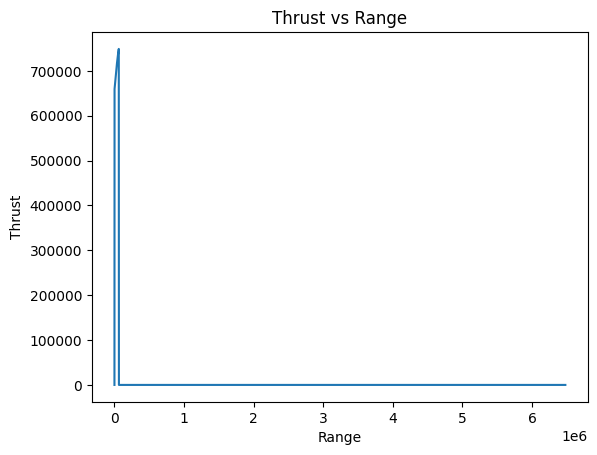

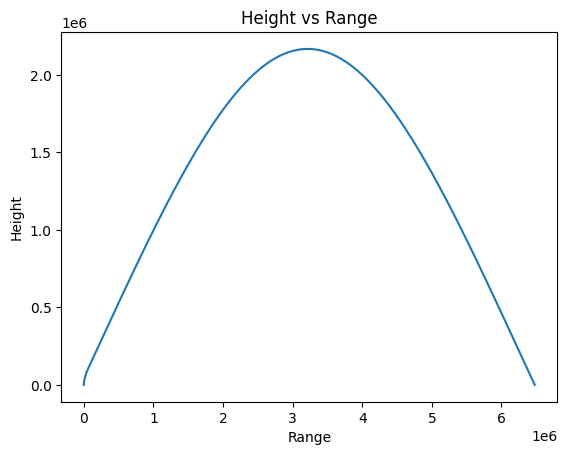

Data written to 'results/results_7.txt'

New simulation 

fuelmass: 5650.802807565196
Isp0: 664.4293845746088
drymass: 1341.3359487176863
thrust0: 51152.77241169228


Stage 1 burnout
Velocity (km/s):  9.325642514673866
Angle (deg h):  43.71962073976128
Range (km):  124.27498335727124
Time (sec):  73.4000000000001
Final results: 
Range (km):  16074.05879670907
Apogee (km):  14127.440466486996
Time to target (sec):  11282.700000023515




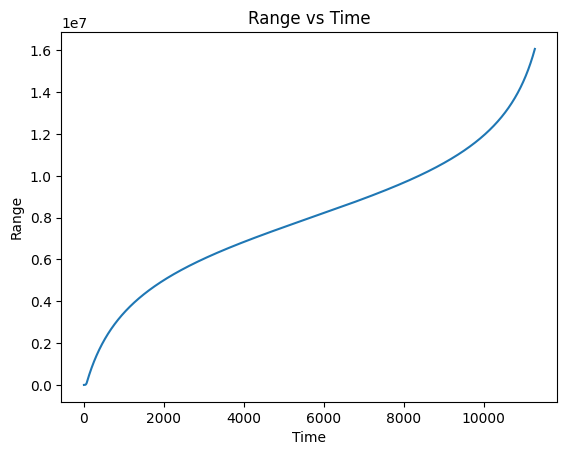

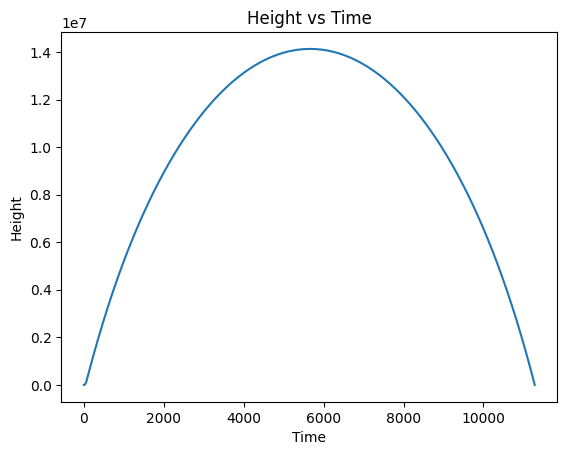

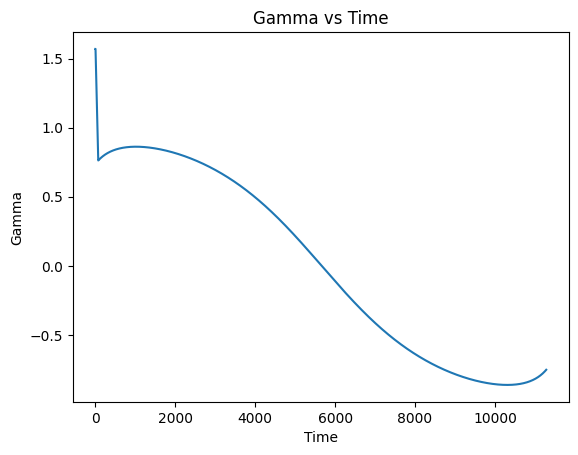

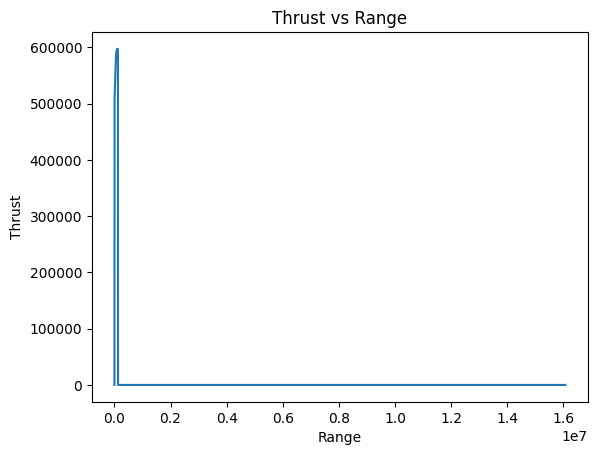

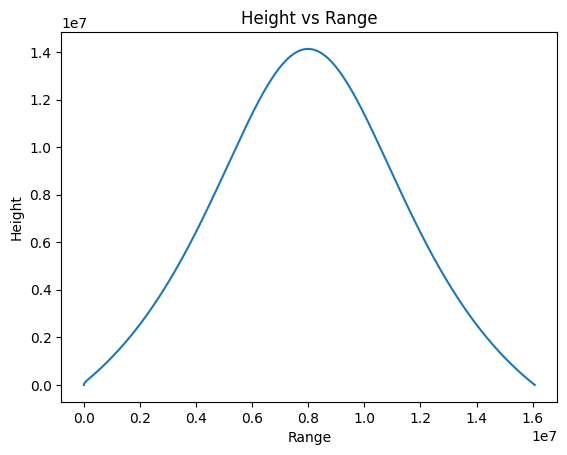

Data written to 'results/results_8.txt'

New simulation 

fuelmass: 5722.639149890681
Isp0: 443.11536999458053
drymass: 1782.7044025265045
thrust0: 68539.79185730914


Stage 1 burnout
Velocity (km/s):  5.137328797164934
Angle (deg h):  43.78731141853653
Range (km):  35.784046191016415
Time (sec):  37.000000000000256
Final results: 
Range (km):  3505.0454961676687
Apogee (km):  1012.7338473159605
Time to target (sec):  1169.300000000032




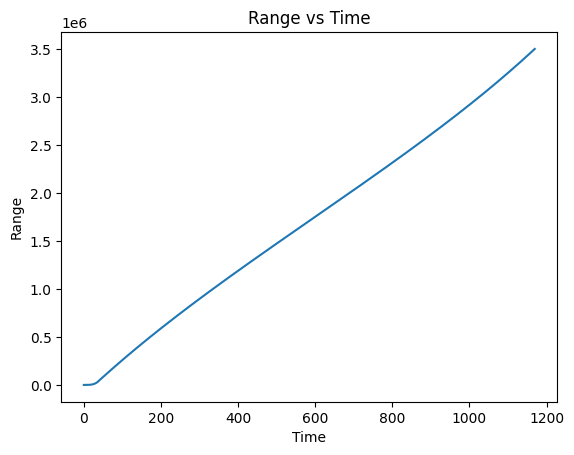

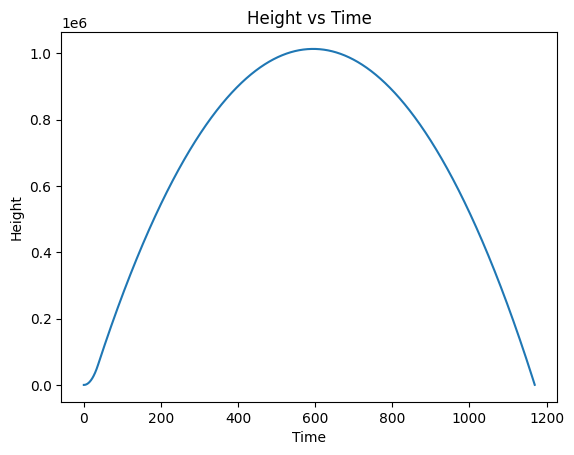

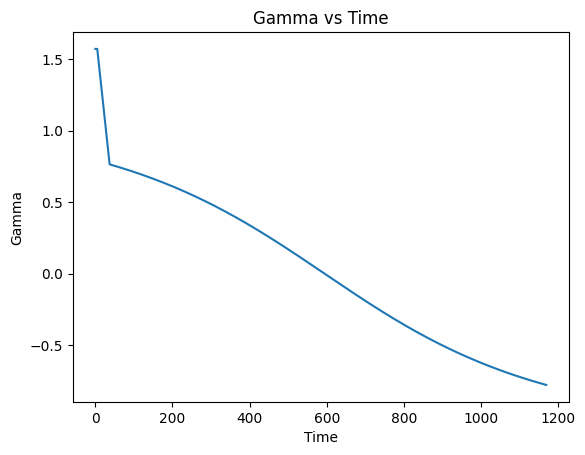

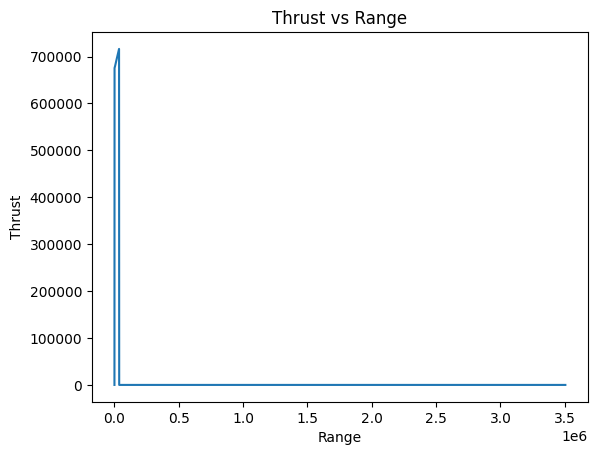

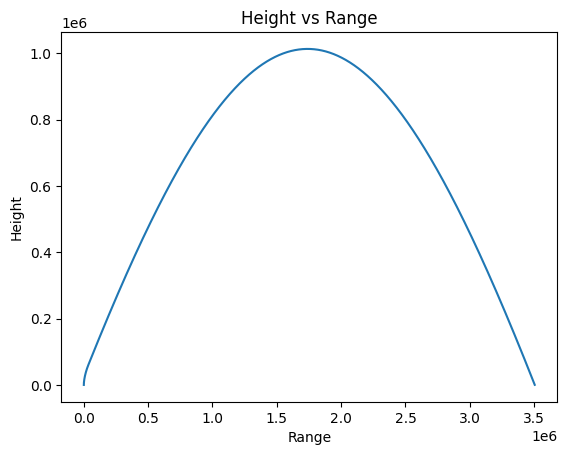

Data written to 'results/results_9.txt'

New simulation 

fuelmass: 3600.520304429098
Isp0: 139.42937911797583
drymass: 2977.676406916617
thrust0: 57492.180537868604


Stage 1 burnout
Velocity (km/s):  0.872143253551159
Angle (deg h):  44.000924450579795
Range (km):  1.0380335067925008
Time (sec):  8.799999999999986
Final results: 
Range (km):  82.1849942216712
Apogee (km):  21.985038575349567
Time to target (sec):  138.6999999999964




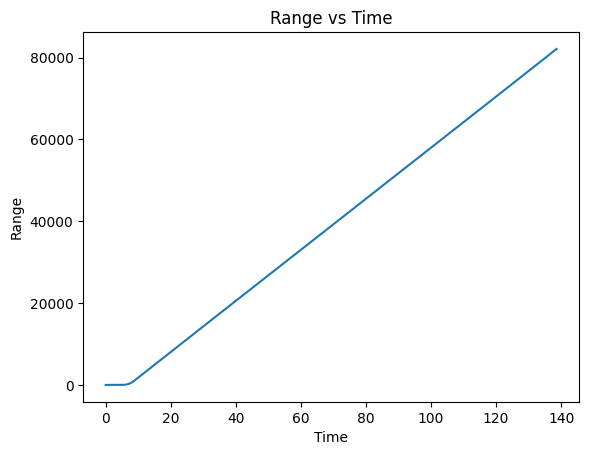

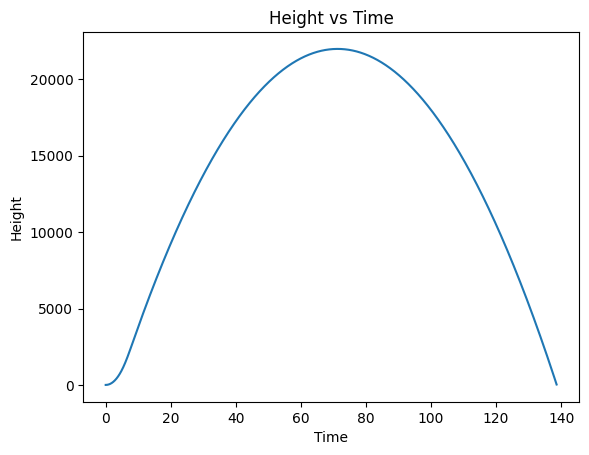

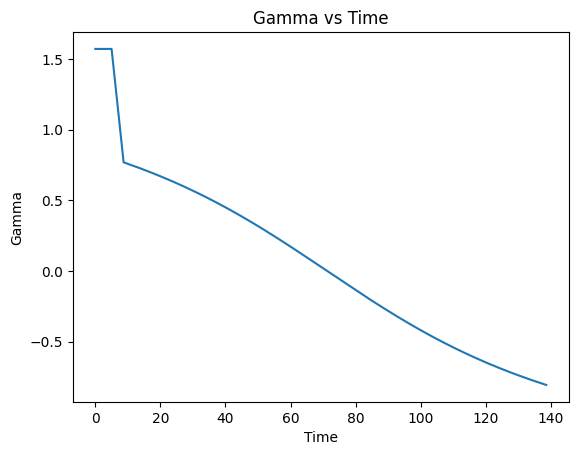

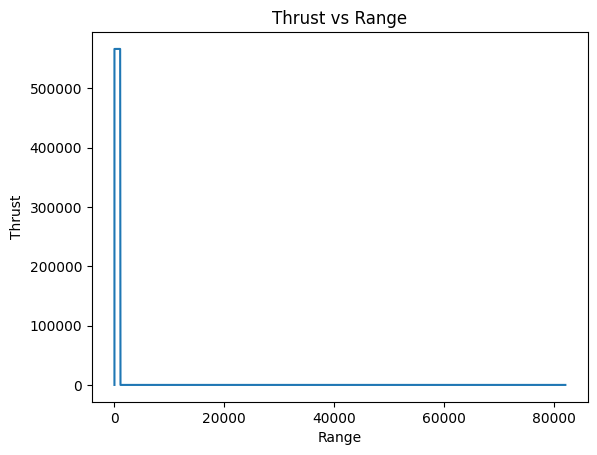

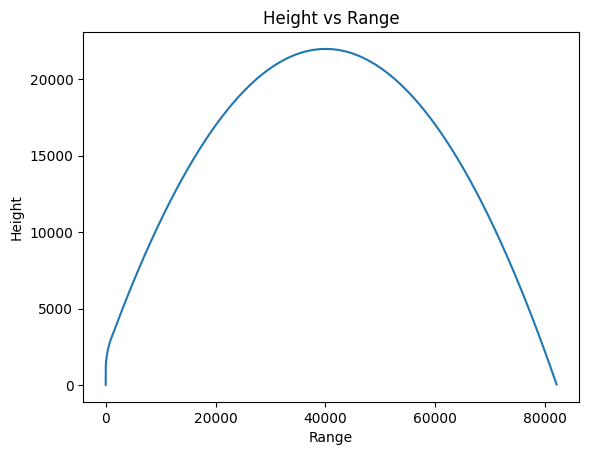

Data written to 'results/results_10.txt'

New simulation 

fuelmass: 3367.929934673433
Isp0: 446.1129667466869
drymass: 2075.687227719486
thrust0: 32663.25337961509


Stage 1 burnout
Velocity (km/s):  3.192001062621664
Angle (deg h):  43.752237942507534
Range (km):  29.76928530381924
Time (sec):  46.000000000000384
Final results: 
Range (km):  1221.9689444912015
Apogee (km):  338.60296845615363
Time to target (sec):  597.1000000000672




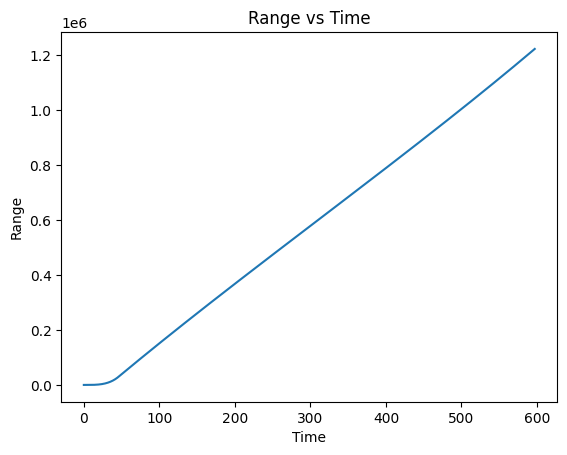

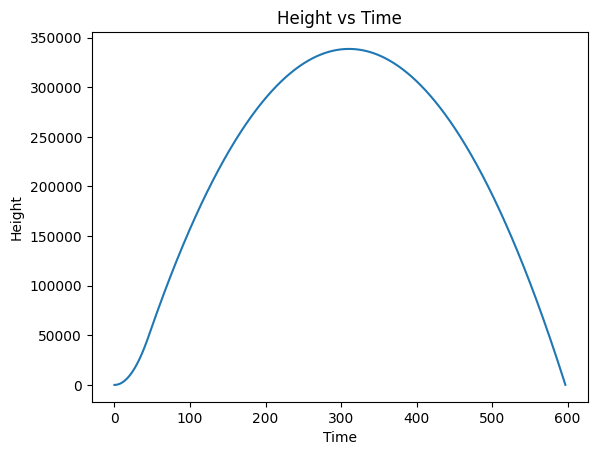

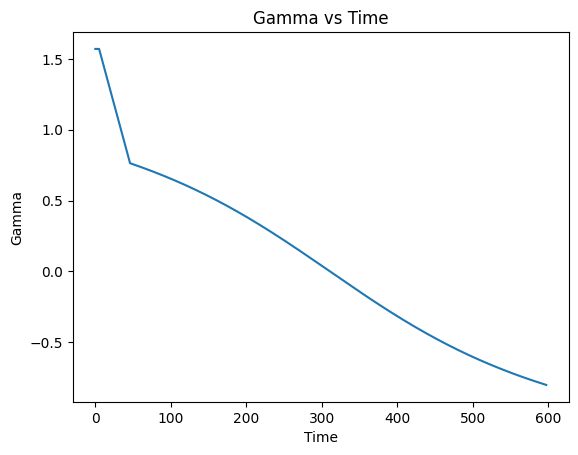

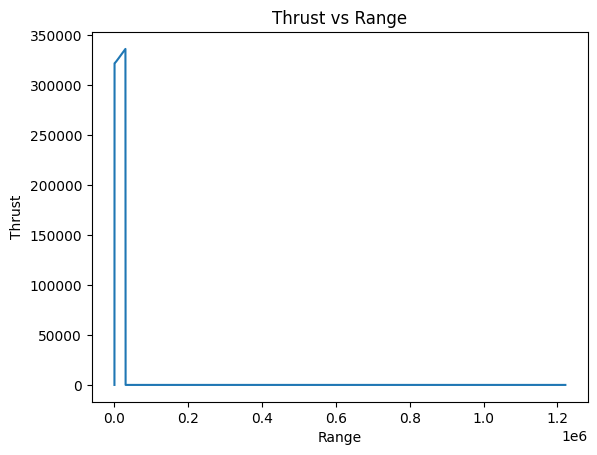

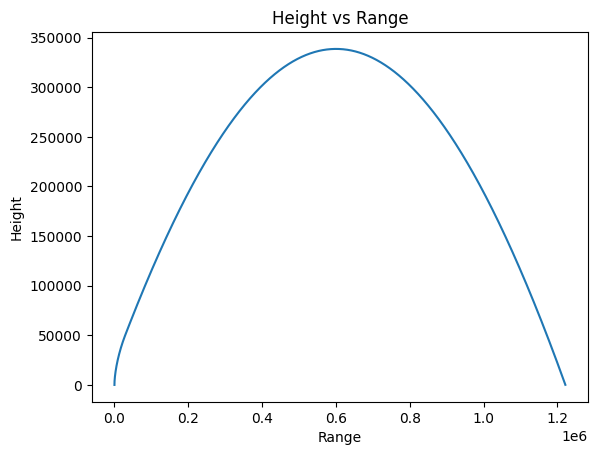

Data written to 'results/results_11.txt'


In [11]:
wirte_output_txt = True


# from emukit.core.initial_designs.latin_design import LatinDesign
# design = LatinDesign(parameter_space) 

m3_design = RandomDesign(m3_space)
m3_x = m3_design.get_samples(3*4)
m3_y = neg_run_missile_sim(m3_x)


In [12]:
# Build model
m3_var_kernel = (100)**2 
m3_lengthscale = 100 # 1
m3_var_noise = 1e-5 # small value

constrain_lengthscale = True


m3_rbf_kern = GPy.kern.RBF(input_dim=nr_custom_params, lengthscale=m3_lengthscale)
if constrain_lengthscale:
    m3_rbf_kern.lengthscale.constrain_bounded(m3_lengthscale, m3_lengthscale*1e12)

m3_kern = m3_rbf_kern + \
    GPy.kern.Linear(input_dim=nr_custom_params)

m3_model_gpy = GPRegression(m3_x,m3_y, kernel=m3_kern)
m3_model_gpy.kern.variance =  m3_var_kernel 
m3_model_gpy.likelihood.variance.fix(m3_var_noise)  

display(m3_model_gpy)





reconstraining parameters rbf.lengthscale


GP_regression.,value,constraints,priors
sum.rbf.variance,1.0,+ve,
sum.rbf.lengthscale,100.0,"100.0,100000000000000.0",
sum.linear.variances,1.0,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [13]:
m3_model_emukit = GPyModelWrapper(m3_model_gpy)
m3_model_emukit.optimize()

In [14]:
display(m3_model_gpy)



GP_regression.,value,constraints,priors
sum.rbf.variance,4220611.244162366,+ve,
sum.rbf.lengthscale,100.0000000001,"100.0,100000000000000.0",
sum.linear.variances,5.562684646268137e-309,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [15]:
# # Exact optimization: 
# # - opt1: Greedy: compute simulation on a grid and find maximum
# # - opt2: Minimize package

wirte_output_txt = False
from scipy.optimize import minimize
# # opt2
# func_to_minimize = lambda x: (x[0] - 1)**2 + (x[1] - 2.5)**2  
def func_to_minimize(x):
    print(x)
    return neg_run_missile_sim(np.array(x).reshape(1,nr_custom_params))

# Function taking 6 inputs and returning the -range of the simulation run with those 6 params and 
# the others set as defaut
bnds = [(m3_domain_param_1),
        (m3_domain_param_2),
        (m3_domain_param_3),
        (m3_domain_param_4),
#         (m3_domain_param_5),
#         (m3_domain_param_6)
       ]


initial_guess = [np.mean(m3_domain_param_1),
                 np.mean(m3_domain_param_2),
                 np.mean(m3_domain_param_3),
                 np.mean(m3_domain_param_4),
#                  np.mean(m3_domain_param_5),
#                  np.mean(m3_domain_param_6)
                ]
true_minim = minimize(func_to_minimize, initial_guess, bounds=bnds) # , method='SLSQP'constraints=cons



[ 3250.   450.  2000. 39500.]

New simulation 

fuelmass: 3250.0
Isp0: 450.0
drymass: 2000.0
thrust0: 39500.0


Stage 1 burnout
Velocity (km/s):  3.265595650135737
Angle (deg h):  43.67723082354777
Range (km):  24.478932233595803
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.5961059554932
Apogee (km):  344.1630357716314
Time to target (sec):  598.3000000000675


[ 3250.00000001   450.          2000.         39500.        ]

New simulation 

fuelmass: 3250.00000001
Isp0: 450.0
drymass: 2000.0
thrust0: 39500.0


Stage 1 burnout
Velocity (km/s):  3.2655956501256957
Angle (deg h):  43.6772308237112
Range (km):  24.478932233455883
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.596105948389
Apogee (km):  344.1630357711632
Time to target (sec):  598.3000000000675


[ 3250.           450.00000001  2000.         39500.        ]

New simulation 

fuelmass: 3250.0
Isp0: 450.00000001
drymass: 2000.0
thrust0: 39500.0


Stage 1 burnout
Velocity (km/s):  3.2655956

Final results: 
Range (km):  1265.6184188138257
Apogee (km):  344.16180003058287
Time to target (sec):  598.3000000000675


[ 3249.99919961   449.9950651   1999.99966788 39500.00009504]

New simulation 

fuelmass: 3249.999199610407
Isp0: 449.9950650974901
drymass: 1999.9996678836703
thrust0: 39500.00009504344


Stage 1 burnout
Velocity (km/s):  3.265619739370602
Angle (deg h):  43.67663032621853
Range (km):  24.479328246429386
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.6184188175228
Apogee (km):  344.16180003298564
Time to target (sec):  598.3000000000675


[ 3249.99842576   449.99029384  1999.99934678 39500.00018692]

New simulation 

fuelmass: 3249.9984257618607
Isp0: 449.99029383713753
drymass: 1999.9993467803713
thrust0: 39500.00018691556


Stage 1 burnout
Velocity (km/s):  3.2656430306924014
Angle (deg h):  43.67604972697668
Range (km):  24.47971113892694
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.6399925235085
Apogee (km):  344.16060516

Final results: 
Range (km):  1265.6502620657077
Apogee (km):  344.1600363519939
Time to target (sec):  598.3000000000675


[ 3249.9980574    449.98802268  1999.99919393 39500.00023065]

New simulation 

fuelmass: 3249.998057402487
Isp0: 449.9880226811762
drymass: 1999.999193932103
thrust0: 39500.00023065233


Stage 1 burnout
Velocity (km/s):  3.26565411784872
Angle (deg h):  43.67577335230318
Range (km):  24.479893402668107
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.6502620289614
Apogee (km):  344.1600363551515
Time to target (sec):  598.3000000000675


[ 3249.9980574    449.98802267  1999.99919394 39500.00023065]

New simulation 

fuelmass: 3249.998057402487
Isp0: 449.98802267117617
drymass: 1999.999193942103
thrust0: 39500.00023065233


Stage 1 burnout
Velocity (km/s):  3.26565411788537
Angle (deg h):  43.67577335111152
Range (km):  24.479893403380125
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.6502620699382
Apogee (km):  344.1600363502034
T

Final results: 
Range (km):  1265.855932475447
Apogee (km):  344.14864146515544
Time to target (sec):  598.3000000000675


[ 3249.98818913   449.92717859  1999.99509916 39500.00140235]

New simulation 

fuelmass: 3249.98818912851
Isp0: 449.92717858919286
drymass: 1999.9950991575563
thrust0: 39500.00140235176


Stage 1 burnout
Velocity (km/s):  3.2505883393186124
Angle (deg h):  43.67858270954315
Range (km):  24.25040799006716
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1811019189188
Apogee (km):  340.76532695907855
Time to target (sec):  594.9000000000667


[ 3249.98818914   449.92717859  1999.99509916 39500.00140235]

New simulation 

fuelmass: 3249.98818913851
Isp0: 449.92717858919286
drymass: 1999.9950991575563
thrust0: 39500.00140235176


Stage 1 burnout
Velocity (km/s):  3.250588339308637
Angle (deg h):  43.6785827097066
Range (km):  24.250407989928572
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1811019118843
Apogee (km):  340.7653269586

Final results: 
Range (km):  1253.1471541018566
Apogee (km):  340.76726311812877
Time to target (sec):  594.9000000000667


[ 3249.98942049   449.93477072  1999.9956101  39500.00125616]

New simulation 

fuelmass: 3249.989420492926
Isp0: 449.9347707210758
drymass: 1999.9956101040177
thrust0: 39500.00125615696


Stage 1 burnout
Velocity (km/s):  3.2505516324392976
Angle (deg h):  43.67950687159011
Range (km):  24.24980475084437
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1471541055562
Apogee (km):  340.7672631205292
Time to target (sec):  594.9000000000667


[ 3249.9906513    449.94235944  1999.99612082 39500.00111001]

New simulation 

fuelmass: 3249.990651304277
Isp0: 449.94235944296554
drymass: 1999.9961208209884
thrust0: 39500.00111000783


Stage 1 burnout
Velocity (km/s):  3.2658770753266357
Angle (deg h):  43.67021595289505
Range (km):  24.483558492550614
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.856773008944
Apogee (km):  344.148594883

Final results: 
Range (km):  1232.147327156073
Apogee (km):  335.2009396584592
Time to target (sec):  589.2000000000654


[ 3249.27848492   445.55166465  1999.70120869 39500.07596477]

New simulation 

fuelmass: 3249.278484917429
Isp0: 445.55166464920364
drymass: 1999.7012086857324
thrust0: 39500.07596476959


Stage 1 burnout
Velocity (km/s):  3.2257612160839564
Angle (deg h):  43.71525343125608
Range (km):  23.898835799987683
Time (sec):  36.70000000000025
Final results: 
Range (km):  1232.1473271199452
Apogee (km):  335.2009396616527
Time to target (sec):  589.2000000000654


[ 3249.27848492   445.55166464  1999.7012087  39500.07596477]

New simulation 

fuelmass: 3249.278484917429
Isp0: 445.55166463920364
drymass: 1999.7012086957322
thrust0: 39500.07596476959


Stage 1 burnout
Velocity (km/s):  3.225761216120301
Angle (deg h):  43.71525343005399
Range (km):  23.89883580068831
Time (sec):  36.70000000000025
Final results: 
Range (km):  1232.1473271601342
Apogee (km):  335.20093965673

Final results: 
Range (km):  1265.873956058462
Apogee (km):  344.14764259866496
Time to target (sec):  598.3000000000675


[ 3249.99003519   449.93856063  1999.99586516 39500.00118316]

New simulation 

fuelmass: 3249.990035187053
Isp0: 449.93856063338455
drymass: 1999.9958651634747
thrust0: 39500.001183156994


Stage 1 burnout
Velocity (km/s):  3.26589562718592
Angle (deg h):  43.66975356373643
Range (km):  24.483863444886044
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.873956051274
Apogee (km):  344.14764259822704
Time to target (sec):  598.3000000000675


[ 3249.99003518   449.93856064  1999.99586516 39500.00118316]

New simulation 

fuelmass: 3249.990035177053
Isp0: 449.93856064338456
drymass: 1999.9958651634747
thrust0: 39500.001183156994


Stage 1 burnout
Velocity (km/s):  3.265895627149345
Angle (deg h):  43.66975356476236
Range (km):  24.483863444250595
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.87395601451
Apogee (km):  344.14764260139

Final results: 
Range (km):  1265.8796023634266
Apogee (km):  344.1473295690826
Time to target (sec):  598.3000000000675


[ 3249.98983271   449.93731232  1999.99578132 39500.00120444]

New simulation 

fuelmass: 3249.989832711862
Isp0: 449.9373123201527
drymass: 1999.9957813174979
thrust0: 39500.00120443648


Stage 1 burnout
Velocity (km/s):  3.2659017230066953
Angle (deg h):  43.66960162119941
Range (km):  24.483963650479392
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.879602356249
Apogee (km):  344.1473295686492
Time to target (sec):  598.3000000000675


[ 3249.9898327    449.93731233  1999.99578132 39500.00120444]

New simulation 

fuelmass: 3249.9898327018623
Isp0: 449.93731233015274
drymass: 1999.9957813174979
thrust0: 39500.00120443648


Stage 1 burnout
Velocity (km/s):  3.26590172297025
Angle (deg h):  43.66960162222534
Range (km):  24.4839636498447
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8796023195246
Apogee (km):  344.1473295718446

Final results: 
Range (km):  1253.138482731594
Apogee (km):  340.7677574991777
Time to target (sec):  594.9000000000667


[ 3249.989735     449.93670998  1999.99574086 39500.00121471]

New simulation 

fuelmass: 3249.989735002589
Isp0: 449.9367099782319
drymass: 1999.9957408597463
thrust0: 39500.00121471435


Stage 1 burnout
Velocity (km/s):  3.250542255925388
Angle (deg h):  43.6797429296356
Range (km):  24.24965066226705
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.138482735365
Apogee (km):  340.7677575015496
Time to target (sec):  594.9000000000667


[ 3249.98982511   449.93726553  1999.99577817 39500.00120523]

New simulation 

fuelmass: 3249.989825113201
Isp0: 449.937265534045
drymass: 1999.9957781749958
thrust0: 39500.001205234024


Stage 1 burnout
Velocity (km/s):  3.2659019514860366
Angle (deg h):  43.66959592629148
Range (km):  24.483967406287054
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8798139848432
Apogee (km):  344.14731783679275

Final results: 
Range (km):  1265.8810888943271
Apogee (km):  344.1472471557823
Time to target (sec):  598.3000000000675


[ 3249.98977939   449.93698366  1999.99575925 39500.00121004]

New simulation 

fuelmass: 3249.9897793939326
Isp0: 449.9369836626353
drymass: 1999.9957592524208
thrust0: 39500.001210038965


Stage 1 burnout
Velocity (km/s):  3.2659033279324072
Angle (deg h):  43.6695616172457
Range (km):  24.483990032942238
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8810889352314
Apogee (km):  344.1472471508365
Time to target (sec):  598.3000000000675


[ 3249.98977939   449.93698366  1999.99575924 39500.00121005]

New simulation 

fuelmass: 3249.9897793939326
Isp0: 449.9369836626353
drymass: 1999.995759242421
thrust0: 39500.00121004896


Stage 1 burnout
Velocity (km/s):  3.2659033279437857
Angle (deg h):  43.66956161723067
Range (km):  24.48399003302371
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8810889389795
Apogee (km):  344.1472471532

Final results: 
Range (km):  1253.415004406673
Apogee (km):  340.75483985605337
Time to target (sec):  594.9000000000667


[ 3249.97069612   449.87712021  1999.98461163 39500.01921759]

New simulation 

fuelmass: 3249.9706961246216
Isp0: 449.87712021215305
drymass: 1999.984611626564
thrust0: 39500.01921758561


Stage 1 burnout
Velocity (km/s):  3.2508493198486086
Angle (deg h):  43.672311038241546
Range (km):  24.25458920943365
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.4150043996356
Apogee (km):  340.7548398555942
Time to target (sec):  594.9000000000667


[ 3249.97069611   449.87712022  1999.98461163 39500.01921759]

New simulation 

fuelmass: 3249.9706961146217
Isp0: 449.87712022215305
drymass: 1999.984611626564
thrust0: 39500.01921758561


Stage 1 burnout
Velocity (km/s):  3.2508493198124344
Angle (deg h):  43.67231103926746
Range (km):  24.254589208804777
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.4150043632947
Apogee (km):  340.754839

Final results: 
Range (km):  1265.88172539649
Apogee (km):  344.14721186807833
Time to target (sec):  598.3000000000675


[ 3249.98972156   449.93673327  1999.99572933 39500.00124551]

New simulation 

fuelmass: 3249.989721563824
Isp0: 449.9367332667356
drymass: 1999.9957293343964
thrust0: 39500.00124550727


Stage 1 burnout
Velocity (km/s):  3.2505421781011807
Angle (deg h):  43.679745438335004
Range (km):  24.249649185387895
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1383970380732
Apogee (km):  340.7677676482096
Time to target (sec):  594.9000000000667


[ 3249.98972157   449.93673327  1999.99572933 39500.00124551]

New simulation 

fuelmass: 3249.9897215738238
Isp0: 449.9367332667356
drymass: 1999.9957293343964
thrust0: 39500.00124550727


Stage 1 burnout
Velocity (km/s):  3.2505421780912043
Angle (deg h):  43.67974543850131
Range (km):  24.24964918524769
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1383970309648
Apogee (km):  340.76776764

Final results: 
Range (km):  1253.1381436261574
Apogee (km):  340.76777948706166
Time to target (sec):  594.9000000000667


[ 3249.98973899   449.93678788  1999.99573953 39500.00122904]

New simulation 

fuelmass: 3249.9897389945945
Isp0: 449.93678788313224
drymass: 1999.995739530238
thrust0: 39500.001229041576


Stage 1 burnout
Velocity (km/s):  3.2505418967588477
Angle (deg h):  43.679752248544794
Range (km):  24.249644660209213
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1381436666113
Apogee (km):  340.7677794820681
Time to target (sec):  594.9000000000667


[ 3249.98973899   449.93678788  1999.99573952 39500.00122905]

New simulation 

fuelmass: 3249.9897389945945
Isp0: 449.93678788313224
drymass: 1999.9957395202382
thrust0: 39500.00122905157


Stage 1 burnout
Velocity (km/s):  3.2505418967702884
Angle (deg h):  43.67975224853197
Range (km):  24.24964466028905
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1381436703173
Apogee (km):  340.767

Final results: 
Range (km):  1265.881727517046
Apogee (km):  344.14721177137466
Time to target (sec):  598.3000000000675


[ 3249.98975643   449.93684251  1999.99574971 39500.00121258]

New simulation 

fuelmass: 3249.9897564252337
Isp0: 449.9368425091171
drymass: 1999.9957497060032
thrust0: 39500.00121257601


Stage 1 burnout
Velocity (km/s):  3.2659040173843032
Angle (deg h):  43.669544434800045
Range (km):  24.484001365474395
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8817274803444
Apogee (km):  344.14721177459114
Time to target (sec):  598.3000000000675


[ 3249.98975643   449.9368425   1999.99574972 39500.00121258]

New simulation 

fuelmass: 3249.9897564252337
Isp0: 449.9368424991171
drymass: 1999.995749716003
thrust0: 39500.00121257601


Stage 1 burnout
Velocity (km/s):  3.2659040174207297
Angle (deg h):  43.66954443360777
Range (km):  24.4840013661852
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8817275212755
Apogee (km):  344.147211769

Final results: 
Range (km):  1265.8818338898318
Apogee (km):  344.1472069717135
Time to target (sec):  598.3000000000675


[ 3249.9897492    449.93681983  1999.99574548 39500.00121941]

New simulation 

fuelmass: 3249.9897492015216
Isp0: 449.93681983349325
drymass: 1999.9957454789126
thrust0: 39500.00121940922


Stage 1 burnout
Velocity (km/s):  3.2659041353340075
Angle (deg h):  43.66954160759954
Range (km):  24.484003263484563
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.881833882642
Apogee (km):  344.14720697127746
Time to target (sec):  598.3000000000675


[ 3249.98974919   449.93681984  1999.99574548 39500.00121941]

New simulation 

fuelmass: 3249.9897491915217
Isp0: 449.93681984349325
drymass: 1999.9957454789126
thrust0: 39500.00121940922


Stage 1 burnout
Velocity (km/s):  3.2659041352975198
Angle (deg h):  43.66954160862548
Range (km):  24.484003262849665
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818338459137
Apogee (km):  344.147206

Final results: 
Range (km):  1265.8818358986773
Apogee (km):  344.14720687872176
Time to target (sec):  598.3000000000675


[ 3249.98974905   449.9368194   1999.9957454  39500.00121955]

New simulation 

fuelmass: 3249.989749054702
Isp0: 449.9368194047908
drymass: 1999.9957453989605
thrust0: 39500.00121954846


Stage 1 burnout
Velocity (km/s):  3.2659041375758426
Angle (deg h):  43.66954155396463
Range (km):  24.484003299530208
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818359024656
Apogee (km):  344.14720688112084
Time to target (sec):  598.3000000000675


[ 3249.54800483   448.55131834  1999.73736636 39500.42013154]

New simulation 

fuelmass: 3249.5480048320605
Isp0: 448.55131833893967
drymass: 1999.7373663551214
thrust0: 39500.42013153759


Stage 1 burnout
Velocity (km/s):  3.2423478337240743
Angle (deg h):  43.65167163375321
Range (km):  24.131040156413963
Time (sec):  36.900000000000254
Final results: 
Range (km):  1246.1689656008718
Apogee (km):  338.51058

Final results: 
Range (km):  1265.8818359085924
Apogee (km):  344.14720687983805
Time to target (sec):  598.3000000000675


[ 3249.98974905   449.93681941  1999.9957454  39500.00121954]

New simulation 

fuelmass: 3249.9897490537464
Isp0: 449.9368194117945
drymass: 1999.9957453984016
thrust0: 39500.00121953937


Stage 1 burnout
Velocity (km/s):  3.265904137543427
Angle (deg h):  43.66954155479514
Range (km):  24.48400329898954
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818358718693
Apogee (km):  344.14720688303635
Time to target (sec):  598.3000000000675


[ 3249.98974905   449.9368194   1999.99574541 39500.00121954]

New simulation 

fuelmass: 3249.9897490537464
Isp0: 449.9368194017945
drymass: 1999.9957454084015
thrust0: 39500.00121953937


Stage 1 burnout
Velocity (km/s):  3.2659041375799394
Angle (deg h):  43.66954155360573
Range (km):  24.484003299699218
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.881835912753
Apogee (km):  344.147206878

Final results: 
Range (km):  1265.8818360891562
Apogee (km):  344.147206871732
Time to target (sec):  598.3000000000675


[ 3249.98974904   449.93681937  1999.99574539 39500.00121955]

New simulation 

fuelmass: 3249.9897490414764
Isp0: 449.93681937331024
drymass: 1999.9957453912248
thrust0: 39500.001219551006


Stage 1 burnout
Velocity (km/s):  3.2659041377435742
Angle (deg h):  43.66954154999823
Range (km):  24.48400330220966
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818360524015
Apogee (km):  344.14720687489176
Time to target (sec):  598.3000000000675


[ 3249.98974904   449.93681936  1999.9957454  39500.00121955]

New simulation 

fuelmass: 3249.9897490414764
Isp0: 449.93681936331024
drymass: 1999.9957454012247
thrust0: 39500.001219551006


Stage 1 burnout
Velocity (km/s):  3.2659041377802365
Angle (deg h):  43.66954154880656
Range (km):  24.484003302921753
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.881836093386
Apogee (km):  344.147206

Final results: 
Range (km):  1253.1381259721607
Apogee (km):  340.7677803100325
Time to target (sec):  594.9000000000667


[ 3249.98974022   449.93679171  1999.99574023 39500.00122792]

New simulation 

fuelmass: 3249.989740220058
Isp0: 449.9367917055239
drymass: 1999.9957402315204
thrust0: 39500.00122791647


Stage 1 burnout
Velocity (km/s):  3.2505418770794337
Angle (deg h):  43.679752725221704
Range (km):  24.249644343552678
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.138125935859
Apogee (km):  340.76778031324864
Time to target (sec):  594.9000000000667


[ 3249.98974022   449.9367917   1999.99574024 39500.00122792]

New simulation 

fuelmass: 3249.989740220058
Isp0: 449.9367916955239
drymass: 1999.9957402415203
thrust0: 39500.00122791647


Stage 1 burnout
Velocity (km/s):  3.2505418771155874
Angle (deg h):  43.67975272402948
Range (km):  24.24964434425696
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1381259763461
Apogee (km):  340.76778030

Final results: 
Range (km):  1253.1380621053643
Apogee (km):  340.7677832946482
Time to target (sec):  594.9000000000667


[ 3249.989749     449.93681923  1999.99574537 39500.00121959]

New simulation 

fuelmass: 3249.9897490003336
Isp0: 449.93681923426914
drymass: 1999.9957453671602
thrust0: 39500.00121959002


Stage 1 burnout
Velocity (km/s):  3.2659041384614325
Angle (deg h):  43.6695415327172
Range (km):  24.484003313787813
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818367018612
Apogee (km):  344.14720684482967
Time to target (sec):  598.3000000000675


[ 3249.98974901   449.93681923  1999.99574537 39500.00121959]

New simulation 

fuelmass: 3249.9897490103335
Isp0: 449.93681923426914
drymass: 1999.9957453671602
thrust0: 39500.00121959002


Stage 1 burnout
Velocity (km/s):  3.265904138451391
Angle (deg h):  43.66954153288349
Range (km):  24.484003313646248
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818366946784
Apogee (km):  344.1472068

Final results: 
Range (km):  1265.8818366990215
Apogee (km):  344.14720684257964
Time to target (sec):  598.3000000000675


[ 3249.989749     449.93681923  1999.99574537 39500.0012196 ]

New simulation 

fuelmass: 3249.989749000326
Isp0: 449.9368192342447
drymass: 1999.9957453671557
thrust0: 39500.001219600024


Stage 1 burnout
Velocity (km/s):  3.2659041384629868
Angle (deg h):  43.66954153270092
Range (km):  24.484003313805395
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.881836702739
Apogee (km):  344.1472068450001
Time to target (sec):  598.3000000000675


[ 3249.989749     449.93681923  1999.99574537 39500.00121959]

New simulation 

fuelmass: 3249.9897489994755
Isp0: 449.93681923157783
drymass: 1999.9957453666584
thrust0: 39500.001219590835


Stage 1 burnout
Velocity (km/s):  3.265904138475327
Angle (deg h):  43.669541532382766
Range (km):  24.484003314011833
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818367144354
Apogee (km):  344.147206

Final results: 
Range (km):  1253.1594196892067
Apogee (km):  340.7665646944736
Time to target (sec):  594.9000000000667


[ 3249.98897221   449.93202838  1999.99542226 39500.00131039]

New simulation 

fuelmass: 3249.988972214733
Isp0: 449.93202838454795
drymass: 1999.9954222623605
thrust0: 39500.00131039339


Stage 1 burnout
Velocity (km/s):  3.2505648979475477
Angle (deg h):  43.67917300170386
Range (km):  24.25002271433066
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.159419652947
Apogee (km):  340.76656469771564
Time to target (sec):  594.9000000000667


[ 3249.98897221   449.93202837  1999.99542227 39500.00131039]

New simulation 

fuelmass: 3249.988972214733
Isp0: 449.93202837454794
drymass: 1999.9954222723604
thrust0: 39500.00131039339


Stage 1 burnout
Velocity (km/s):  3.250564897983571
Angle (deg h):  43.679173000511625
Range (km):  24.250022715034206
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.15941969339
Apogee (km):  340.766564692

Final results: 
Range (km):  1265.8818420428581
Apogee (km):  344.1472065408321
Time to target (sec):  598.3000000000675


[ 3249.98974883   449.93681805  1999.99574531 39500.00121956]

New simulation 

fuelmass: 3249.989748834592
Isp0: 449.936818047299
drymass: 1999.9957453074028
thrust0: 39500.001219564205


Stage 1 burnout
Velocity (km/s):  3.265904144204073
Angle (deg h):  43.66954138874379
Range (km):  24.484003408489997
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818420421214
Apogee (km):  344.14720654065576
Time to target (sec):  598.3000000000675


[ 3249.98974884   449.93681805  1999.99574531 39500.00121956]

New simulation 

fuelmass: 3249.9897488445918
Isp0: 449.936818047299
drymass: 1999.9957453074028
thrust0: 39500.001219564205


Stage 1 burnout
Velocity (km/s):  3.2659041441940313
Angle (deg h):  43.66954138891009
Range (km):  24.484003408348418
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818420349323
Apogee (km):  344.147206540

Final results: 
Range (km):  1253.1596769736861
Apogee (km):  340.7665504446012
Time to target (sec):  594.9000000000667


[ 3249.98895539   449.93197186  1999.9954184  39500.00130088]

New simulation 

fuelmass: 3249.9889553879857
Isp0: 449.93197185843
drymass: 1999.9954183959157
thrust0: 39500.0013008838


Stage 1 burnout
Velocity (km/s):  3.2505651773704027
Angle (deg h):  43.67916600918976
Range (km):  24.25002729594785
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1596770140986
Apogee (km):  340.76655043964513
Time to target (sec):  594.9000000000667


[ 3249.98895539   449.93197186  1999.99541839 39500.00130089]

New simulation 

fuelmass: 3249.9889553879857
Isp0: 449.93197185843
drymass: 1999.9954183859159
thrust0: 39500.0013008938


Stage 1 burnout
Velocity (km/s):  3.2505651773817124
Angle (deg h):  43.67916600917755
Range (km):  24.25002729602684
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.159677017747
Apogee (km):  340.76655044202533

Final results: 
Range (km):  1265.8818420349323
Apogee (km):  344.1472065402198
Time to target (sec):  598.3000000000675


[ 3249.98974883   449.93681806  1999.99574531 39500.00121956]

New simulation 

fuelmass: 3249.989748834592
Isp0: 449.936818057299
drymass: 1999.9957453074028
thrust0: 39500.001219564205


Stage 1 burnout
Velocity (km/s):  3.265904144157543
Angle (deg h):  43.66954138993542
Range (km):  24.484003407713665
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818419982117
Apogee (km):  344.14720654339976
Time to target (sec):  598.3000000000675


[ 3249.98974883   449.93681805  1999.99574532 39500.00121956]

New simulation 

fuelmass: 3249.989748834592
Isp0: 449.93681804729897
drymass: 1999.9957453174027
thrust0: 39500.001219564205


Stage 1 burnout
Velocity (km/s):  3.2659041441941064
Angle (deg h):  43.669541388743745
Range (km):  24.48400340842512
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818420391594
Apogee (km):  344.14720653

In [16]:
bnds

[[500, 6000], [100, 800], [1000, 3000], [10000, 69000]]

In [17]:
true_minim

      fun: -1265.6440289367115
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.71878126,  4.39015018,  0.29615734, -0.07366721])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 465
      nit: 5
     njev: 93
   status: 0
  success: True
        x: array([ 3249.98974883,   449.93681805,  1999.99574531, 39500.00121956])

In [18]:
# Bayesian optimization using emulator
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop

m3_2_model_emukit = m3_model_emukit

maxim_aquisition = ExpectedImprovement(model=m3_model_emukit)


bayesopt_loop = BayesianOptimizationLoop(model = m3_2_model_emukit,
                                         space = m3_space,
                                         acquisition = maxim_aquisition,
                                         batch_size = 1)

max_iterations = 5*4
# def neg_run_missile_sim(custom_params):
#     return -run_missile_sim(custom_params)

bayesopt_loop.run_loop(neg_run_missile_sim, max_iterations) 



New simulation 

fuelmass: 5878.140162413802
Isp0: 580.7740482823003
drymass: 1516.670952388355
thrust0: 68499.01630600923


Stage 1 burnout
Velocity (km/s):  7.719568734253621
Angle (deg h):  43.690176896065324
Range (km):  70.99336631298783
Time (sec):  49.90000000000044


 /Users/ilariasartori/opt/anaconda3/envs/mlphysical/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Final results: 
Range (km):  10109.208130040233
Apogee (km):  4295.217319913257
Time to target (sec):  3596.899999997824



New simulation 

fuelmass: 4683.381139457579
Isp0: 554.0943250525168
drymass: 2421.5790507540387
thrust0: 49655.085753936626


Stage 1 burnout
Velocity (km/s):  4.835692392214748
Angle (deg h):  43.70573193955871
Range (km):  50.35078483903368
Time (sec):  52.30000000000047
Final results: 
Range (km):  3092.3599079240194
Apogee (km):  893.4004101030255
Time to target (sec):  1080.300000000113



New simulation 

fuelmass: 1562.1523769301873
Isp0: 163.94591315964425
drymass: 2036.9280008729852
thrust0: 48174.70007556208


Stage 1 burnout
Velocity (km/s):  0.6961885956645937
Angle (deg h):  46.03165959158565
Range (km):  0.06617729500076762
Time (sec):  5.299999999999998
Final results: 
Range (km):  51.2686238944058
Apogee (km):  14.573870941627012
Time to target (sec):  111.49999999999794



New simulation 

fuelmass: 4577.989119477269
Isp0: 648.4785052027305
dryma

In [19]:
results = bayesopt_loop.get_results()
results

In [20]:
results.__dict__

{'minimum_location': array([ 5650.80280757,   664.42938457,  1341.33594872, 51152.77241169]),
 'minimum_value': -16073.36356781718,
 'best_found_value_per_iteration': array([ -2273.60093663,  -2273.60093663,  -2273.60093663,  -2273.60093663,
         -2273.60093663,  -2273.60093663,  -2465.93637518,  -6478.5389594 ,
        -16073.36356782, -16073.36356782, -16073.36356782, -16073.36356782,
        -16073.36356782, -16073.36356782, -16073.36356782, -16073.36356782,
        -16073.36356782, -16073.36356782, -16073.36356782, -16073.36356782,
        -16073.36356782, -16073.36356782, -16073.36356782, -16073.36356782,
        -16073.36356782, -16073.36356782, -16073.36356782, -16073.36356782,
        -16073.36356782, -16073.36356782, -16073.36356782, -16073.36356782])}

In [21]:
min_val_from_sim = true_minim.fun
min_loc_from_sim = true_minim.x
min_val_from_emu = results.minimum_value
min_loc_from_emu = results.minimum_location

min_val_diff = min_val_from_sim - min_val_from_emu
min_loc_diff = min_loc_from_sim - min_loc_from_emu

print("Min val from sim - min val from em: \n", min_val_diff)
print('\n')
print("Min location from sim - min location from em: \n", min_loc_diff)
print('\n')
print('\n')
print("Min location from sim: \n", min_loc_from_sim)
print("Min location from emu: \n", min_loc_from_emu)
print('\n')
print('\n')
print("Min value from sim: \n", min_val_from_sim)
print("Min value from emu: \n", min_val_from_emu)

Min val from sim - min val from em: 
 14807.719538880468


Min location from sim - min location from em: 
 [ -2400.81305873   -214.49256653    658.65979659 -11652.77119213]




Min location from sim: 
 [ 3249.98974883   449.93681805  1999.99574531 39500.00121956]
Min location from emu: 
 [ 5650.80280757   664.42938457  1341.33594872 51152.77241169]




Min value from sim: 
 -1265.6440289367115
Min value from emu: 
 -16073.36356781718


In [23]:
bnds

[[500, 6000], [100, 800], [1000, 3000], [10000, 69000]]